# Hydra in combination with Yaml

In [10]:
!pip install hydra-core omegaconf matplotlib torch --quiet

In [23]:
import os

os.makedirs("conf/model", exist_ok=True)
os.makedirs("conf/training", exist_ok=True)

# Main config file (composition entry point)
with open("conf/config.yaml", "w") as f:
    f.write("""
defaults:
  - model: mlp
  - training: simple
  - _self_
""")

# MLP model config using list of layer sizes
with open("conf/model/mlp.yaml", "w") as f:
    f.write("""
layer_sizes: [1, 128, 1]
activation: relu
""")

# Training config
with open("conf/training/simple.yaml", "w") as f:
    f.write("""
epochs: 100
lr: 0.01
batch_size: 32
""")

In [24]:
def print_yaml_file(path):
    print(f"--- {path} ---")
    with open(path, "r") as f:
        print(f.read())

print_yaml_file("conf/config.yaml")
print_yaml_file("conf/model/mlp.yaml")
print_yaml_file("conf/training/simple.yaml")

--- conf/config.yaml ---

defaults:
  - model: mlp
  - training: simple
  - _self_

--- conf/model/mlp.yaml ---

layer_sizes: [1, 128, 1]
activation: relu

--- conf/training/simple.yaml ---

epochs: 100
lr: 0.01
batch_size: 32



In [35]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Generic MLP using layer_sizes from config
class FlexibleMLP(nn.Module):
    def __init__(self, layer_sizes, activation="relu"):
        super().__init__()
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            if i < len(layer_sizes) - 2:
                layers.append(self._get_activation(activation))
        self.net = nn.Sequential(*layers)

    def _get_activation(self, name):
        return {
            "relu": nn.ReLU(),
            "tanh": nn.Tanh(),
            "gelu": nn.GELU(),
        }.get(name, nn.ReLU())

    def forward(self, x):
        return self.net(x)


# Training function
def train_model(cfg, model_name):
    torch.manual_seed(42)

    # Create toy regression dataset: y = sin(x)
    x = torch.linspace(-2 * torch.pi, 2 * torch.pi, 1000).unsqueeze(1)
    y = torch.sin(x)*torch.cos(2*x)

    dataset = TensorDataset(x, y)
    loader = DataLoader(dataset, batch_size=cfg.training.batch_size, shuffle=True)

    model = FlexibleMLP(cfg.model.layer_sizes, activation=cfg.model.activation)
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.training.lr)
    criterion = nn.MSELoss()

    losses = []
    for epoch in range(cfg.training.epochs):
        total_loss = 0
        for xb, yb in loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        losses.append(total_loss / len(loader))

    # Plot loss curve
    plt.figure(figsize=(6, 4))
    plt.plot(losses)
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.grid(True)
    plt.savefig(f"hydra1_{model_name}.png")
    plt.show()

    # Plot test predictions
    with torch.no_grad():
        pred = model(x)

    plt.figure(figsize=(6, 4))
    plt.plot(x.numpy(), y.numpy(), label="True")
    plt.plot(x.numpy(), pred.numpy(), label="Predicted", linestyle="--")
    plt.title("True vs. Predicted")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"hydra2_{model_name}.png")
    plt.show()

In [36]:
print(cfg)

{'model': {'layer_sizes': [1, 64, 1], 'activation': 'relu'}, 'training': {'epochs': 100, 'lr': 0.01, 'batch_size': 32}}



Training model: MLP (Shallow Network (1 hidden layer))


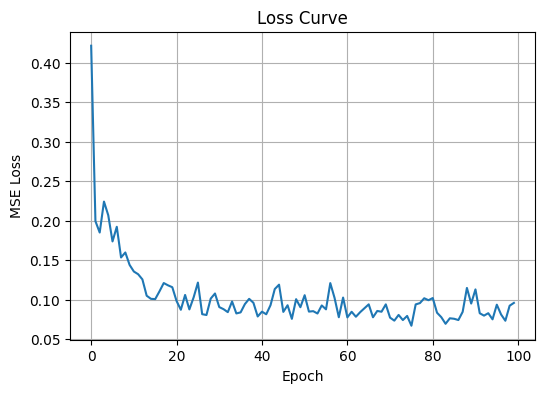

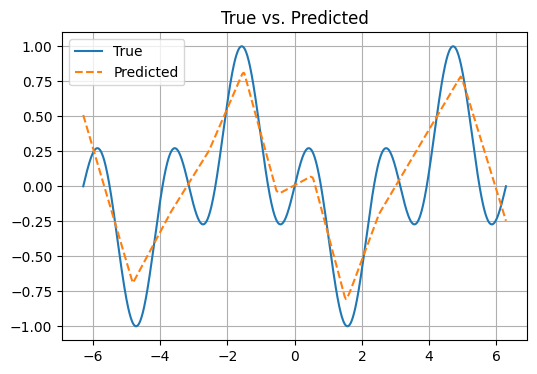


Training model: DEEP (Deeper Network (3 hidden layers))


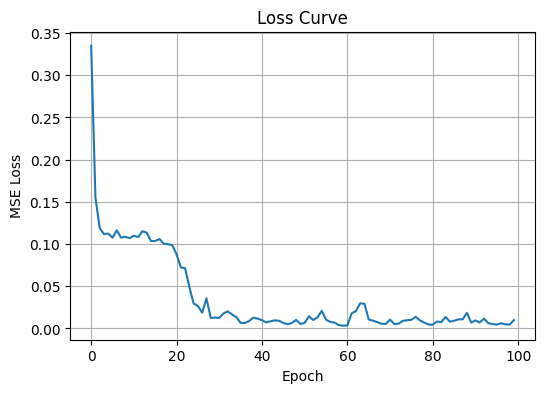

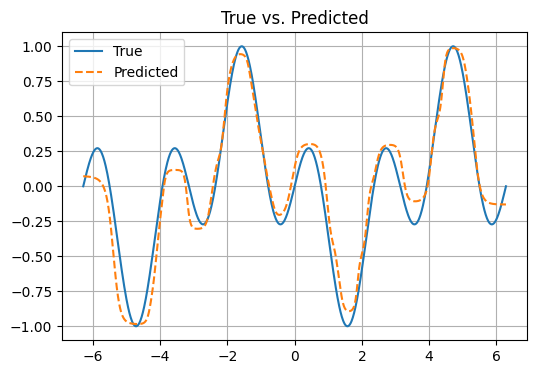

In [37]:
from hydra import initialize, compose

def run_with_override(model_name, title):
    with initialize(config_path="conf", version_base=None):
        cfg = compose(config_name="config", overrides=[f"model={model_name}"])
    print(f"\n{'='*30}\nTraining model: {model_name.upper()} ({title})\n{'='*30}")
    train_model(cfg,model_name)

# Run shallow model
run_with_override("mlp", "Shallow Network (1 hidden layer)")

# Create deep model config if not already created
import os
if not os.path.exists("conf/model/deep.yaml"):
    with open("conf/model/deep.yaml", "w") as f:
        f.write("""
layer_sizes: [1, 128, 64, 32, 1]
activation: tanh
""")

# Run deeper model
run_with_override("deep", "Deeper Network (3 hidden layers)")